---
title: Testing URA API
jupyter:
  jupytext:
    text_representation:
      extension: .qmd
      format_name: quarto
      format_version: '1.0'
      jupytext_version: 1.16.2
  kernelspec:
    display_name: Python 3 (ipykernel)
    language: python
    name: python3
---

In [1]:
import pandas as pd
import requests

#### Chatgpt Answer 

In [2]:
import requests

access_key = '6d30e7c7-cc13-4a36-a193-339a65c18d40'
url = 'https://www.ura.gov.sg/uraDataService/insertNewToken.action'
headers = {
    'AccessKey': access_key,
    'User-Agent': 'curl/7.68.0'
}

response = requests.get(url, headers=headers)
print(response.text)  # Print the response content

{"Status":"Success","Message":"","Result":"N9765cH99a1xFVp3FWq6a1Fd27M0113C4715VavH53zxtqaWY3-Ge67K+E-5VRhDKc1-2N6336yE01-k-u3yE6N9Wfc7J-7475Cd"}


In [3]:
token = response.json().get("Result")

#### Private Property API call 

In [4]:
pp_url = f"https://www.ura.gov.sg/uraDataService/invokeUraDS?service=PMI_Resi_Transaction&batch="
pp_headers = {
    'AccessKey': access_key,
    'Token': token,
    'User-Agent': 'curl/7.68.0'
}

In [5]:
df = pd.DataFrame()
for i in ['1', '2', '3', '4']:
    response = requests.get(pp_url + i, headers=pp_headers)
    test = pd.DataFrame(response.json().get("Result"))
    df = pd.concat([df, test], axis=0)

In [6]:
df.shape

(3967, 6)

In [7]:
df = df.reset_index(drop=True)
df = df.explode('transaction')
df = df.reset_index(drop=True)
df_trans = df.transaction.apply(pd.Series)

In [323]:
final_df = pd.concat([df, df_trans], axis=1)
final_df.shape

(132593, 17)

In [285]:
# Not bad. Saving the file as parquet keeps the data type structures
final_df.to_parquet('ura_02082024.parquet')
df_parquet = pd.read_parquet('ura_02082024.parquet')

#### Processing the data 

In [328]:
del final_df['transaction']
del final_df['x']
del final_df['y']

In [329]:
final_df.columns = ['street', 'project', 'mkt_seg', 'area', 'storey_range', 'units', 'contractDate',
                    'sale_type', 'price', 'type', 'district', 'area_type', 'tenure', 'nettPrice']
final_df['date'] = [i[:2] + "-20" + i[2:] for i in final_df.contractDate]
del final_df['contractDate']

In [330]:
# Combine up nettprice and price, as nettprice may have discounts from new sales
final_df['final_price'] = final_df['nettPrice'].fillna(final_df['price'])
del final_df['nettPrice']
del final_df['price']
final_df.rename(columns={'final_price':'price'}, inplace=True)

In [331]:
final_df = final_df.reindex(final_df.index.repeat(final_df['units']))

In [332]:
final_df.price = final_df.price.astype(float)
final_df.units = final_df.units.astype(float)
final_df.area = final_df.area.astype(float)
final_df['final_price'] = final_df.price / final_df.units
final_df['final_area'] = final_df.area / final_df.units
final_df['final_price'] = [round(i, 2) for i in final_df['final_price']]

In [333]:
final_df['og_lease'] = [i if i == 'Freehold' else i.split(" ")[0] for i in final_df['tenure']]

In [334]:
def get_lease_start_yr(input: str):
    year = input.split(" ")[-1]
    try:
        return int(year)
    except:
        return input

In [335]:
def get_remaining_lease(st_lease, og_lease, date):
    if st_lease == "Freehold":
        return 'Freehold'
    else:
        try:
            lease_used = int(date.split('-')[-1]) - int(st_lease)
            remaining_left = int(og_lease) - int(lease_used)
            return remaining_left
        except:
            return None

In [336]:
final_df['st_lease'] = [get_lease_start_yr(i) for i in final_df['tenure']]
final_df['lease_left'] = [get_remaining_lease(x,y,z) for x,y,z in zip(final_df['st_lease'], final_df['og_lease'], final_df['date'])]

In [337]:
# When there is no date of starting, the housing has not started its lease yet!
final_df['lease_left'] = final_df['lease_left'].fillna(final_df['og_lease'])

In [338]:
final_df.lease_left.value_counts(dropna=False)

lease_left
Freehold    38794
98          13557
97          12397
96           7544
90           6074
            ...  
999             1
16              1
941             1
952             1
106             1
Name: count, Length: 168, dtype: int64

In [339]:
fdf = final_df[['date', 'street', 'project', 'mkt_seg', 'area', 'storey_range', 'units', 'type', 'district', 
                'area_type', 'final_price', 'final_area', 'og_lease', 'st_lease', 'lease_left']
              ].sort_values(['date', 'area_type'], ascending=[True, True]).reset_index(drop=True)

In [340]:
fdf['price_sqm'] = [round(i, 2) for i in fdf['final_price'] / fdf['final_area'] ]
fdf['final_area_sqft'] = fdf['final_area'] * 10.76391042
fdf['price_sq_ft'] = [round(i, 2) for i in fdf['final_price'] / fdf['final_area_sqft'] ]

In [341]:
fdf['date'] = pd.to_datetime(fdf['date'])

In [342]:
fdf = fdf.sort_values("date", ascending=True).reset_index(drop=True)
fdf.head()

date              street               project mkt_seg   area  \
0 2019-07-01  TAI THONG CRESCENT  THE VENUE RESIDENCES     RCR  107.0   
1 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR   92.0   
2 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR   78.0   
3 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR  105.0   
4 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR  105.0   

  storey_range  units                   type district area_type  final_price  \
0        01-05    1.0              Apartment       13    Strata    1725000.0   
1        06-10    1.0  Executive Condominium       19    Strata    1048800.0   
2        06-10    1.0  Executive Condominium       19    Strata     964800.0   
3        11-15    1.0  Executive Condominium       19    Strata    1258400.0   
4        06-10    1.0  Executive Condominium       19    Strata    1289600.0   

   final_area og_lease st_lease lease_left  price_sqm  final_area_sqft  \
0       107.0       99     2012         92   16121.50      1151.738415   
1        92.0       99     2018         98   11400.00       990.279759   
2        78.0       99     2018         98   12369.23       839.585013   
3       105.0       99     2018         98   11984.76      1130.210594   
4       105.0       99     2018         98   12281.90      1130.210594   

   price_sq_ft  
0      1497.74  
1      1059.09  
2      1149.14  
3      1113.42  
4      1141.03

#### Some summary statistics 

In [343]:
fdf.head()

date              street               project mkt_seg   area  \
0 2019-07-01  TAI THONG CRESCENT  THE VENUE RESIDENCES     RCR  107.0   
1 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR   92.0   
2 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR   78.0   
3 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR  105.0   
4 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR  105.0   

  storey_range  units                   type district area_type  final_price  \
0        01-05    1.0              Apartment       13    Strata    1725000.0   
1        06-10    1.0  Executive Condominium       19    Strata    1048800.0   
2        06-10    1.0  Executive Condominium       19    Strata     964800.0   
3        11-15    1.0  Executive Condominium       19    Strata    1258400.0   
4        06-10    1.0  Executive Condominium       19    Strata    1289600.0   

   final_area og_lease st_lease lease_left  price_sqm  final_area_sqft  \
0       107.0       99     2012         92   16121.50      1151.738415   
1        92.0       99     2018         98   11400.00       990.279759   
2        78.0       99     2018         98   12369.23       839.585013   
3       105.0       99     2018         98   11984.76      1130.210594   
4       105.0       99     2018         98   12281.90      1130.210594   

   price_sq_ft  
0      1497.74  
1      1059.09  
2      1149.14  
3      1113.42  
4      1141.03

In [344]:
fdf['type'] = [i.replace("Condominium", "Condo") for i in fdf['type']]
fdf['type'] = [i.replace("Executive Condo", "EC") for i in fdf['type']]
fdf['type'] = [i.replace("Strata", "Stra") for i in fdf['type']]
fdf['type'] = [i.replace("Semi-detached", "Semi-D") for i in fdf['type']]

In [345]:
fdf['area_type'].value_counts(dropna=False)

area_type
Strata    122241
Land       12107
Name: count, dtype: int64

In [346]:
fdf['type'].value_counts(dropna=False)

type
Apartment        53597
Condo            51886
EC               15059
Terrace           6390
Semi-D            3839
Detached          1757
Stra Terrace      1217
Stra Semi-D        474
Stra Detached      129
Name: count, dtype: int64

In [347]:
fdf['mkt_seg'].value_counts(dropna=False)

mkt_seg
OCR    74394
RCR    38882
CCR    21072
Name: count, dtype: int64

In [348]:
fdf[fdf.final_price == fdf.final_price.min()]

date                 street                     project mkt_seg  \
80136 2022-04-01  JALAN CHEMPAKA KUNING  LANDED HOUSING DEVELOPMENT     OCR   
80137 2022-04-01  JALAN CHEMPAKA KUNING  LANDED HOUSING DEVELOPMENT     OCR   

        area storey_range  units     type district area_type  final_price  \
80136  219.9            -    1.0  Terrace       16      Land     320000.0   
80137  219.9            -    1.0  Terrace       16      Land     320000.0   

       final_area og_lease st_lease lease_left  price_sqm  final_area_sqft  \
80136       219.9       70     1964         12    1455.21      2366.983901   
80137       219.9       70     1964         12    1455.21      2366.983901   

       price_sq_ft  
80136       135.19  
80137       135.19

#### Convert district from number to town names 

In [376]:
mapping = [{"01": "Raffles Place, Cecil, Marina, People's Park"}, 
           {"02": "Anson, Tanjong Pagar"}, 
           {"03": "Queenstown, Tiong Bahru"}, 
           {"04": "Telok Blangah, Harbourfront"}, 
           {"05": "Pasir Panjang, Hong Leong Garden, Clementi New Town"}, 
           {"06": "High Street, Beach Road (part)"}, 
           {"07": "Middle Road, Golden Mile"}, 
           {"08": "Little India"}, 
           {"09": "Orchard, Cairnhill, River Valley"}, 
           {"10": "Ardmore, Bukit Timah, Holland Road, Tanglin"}, 
           {"11": "Watten Estate, Novena, Thomson"}, 
           {"12": "Balestier, Toa Payoh, Serangoon"}, 
           {"13": "Macpherson, Braddell"}, 
           {"14": "Geylang, Eunos"}, 
           {"15": "Katong, Joo Chiat, Amber Road"}, 
           {"16": "Bedok, Upper East Coast, Eastwood, Kew Drive"}, 
           {"17": "Loyang, Changi"}, 
           {"18": "Tampines, Pasir Ris"}, 
           {"19": "Serangoon Garden, Hougang, Punggol"}, 
           {"20": "Bishan, Ang Mo Kio"}, 
           {"21": "Upper Bukit Timah, Clementi Park, Ulu Pandan"}, 
           {"22": "Jurong"}, 
           {"23": "Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang"}, 
           {"24": "Lim Chu Kang, Tengah"}, 
           {"25": "Kranji, Woodgrove"}, 
           {"26": "Upper Thomson, Springleaf"}, 
           {"27": "Yishun, Sembawang"}, 
           {"28": "Seletar"}]

In [378]:
fdf.head()

date              street               project mkt_seg   area  \
0 2019-07-01  TAI THONG CRESCENT  THE VENUE RESIDENCES     RCR  107.0   
1 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR   92.0   
2 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR   78.0   
3 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR  105.0   
4 2019-07-01         SUMANG WALK        PIERMONT GRAND     OCR  105.0   

  storey_range  units       type district area_type  final_price  final_area  \
0        01-05    1.0  Apartment       13    Strata    1725000.0       107.0   
1        06-10    1.0         EC       19    Strata    1048800.0        92.0   
2        06-10    1.0         EC       19    Strata     964800.0        78.0   
3        11-15    1.0         EC       19    Strata    1258400.0       105.0   
4        06-10    1.0         EC       19    Strata    1289600.0       105.0   

  og_lease st_lease lease_left  price_sqm  final_area_sqft  price_sq_ft  
0       99     2012         92   16121.50      1151.738415      1497.74  
1       99     2018         98   11400.00       990.279759      1059.09  
2       99     2018         98   12369.23       839.585013      1149.14  
3       99     2018         98   11984.76      1130.210594      1113.42  
4       99     2018         98   12281.90      1130.210594      1141.03

#### Convert to public housing table format
['month', 'town', 'flat', 'block', 'street_name', 'storey_range', 'lease_mths', 'area_sqm', 'area_sq_ft', 'price_sq_m', 'price_sq_ft', 'price']

In [373]:
ff = fdf[['date', 'street', 'project', 'mkt_seg', 'storey_range', 'district', 'type', 'area_type', 
          'lease_left', 'area', 'final_area', 'final_area_sqft', 'price_sqm', 'price_sq_ft', 'final_price', ]]

ff['street_name'] = ff['street'] + ' - ' + ff['project']
del ff['area_type']
del ff['area']
del ff['street']
del ff['project']

ff.rename(columns={'type':'flat', 'date':'month', 'final_area': 'area_sqm', 'final_area_sqft': 'area_sq_ft',
                   'district': 'town', 'final_price': 'price'}, inplace=True)

ff = ff[['month', 'street_name', 'mkt_seg', 'storey_range', 'town', 'flat', 'lease_left',
         'area_sqm', 'area_sq_ft', 'price_sqm', 'price_sq_ft', 'price']]

ff.head()

month                                street_name mkt_seg storey_range  \
0 2019-07-01  TAI THONG CRESCENT - THE VENUE RESIDENCES     RCR        01-05   
1 2019-07-01               SUMANG WALK - PIERMONT GRAND     OCR        06-10   
2 2019-07-01               SUMANG WALK - PIERMONT GRAND     OCR        06-10   
3 2019-07-01               SUMANG WALK - PIERMONT GRAND     OCR        11-15   
4 2019-07-01               SUMANG WALK - PIERMONT GRAND     OCR        06-10   

  town       flat lease_left  area_sqm   area_sq_ft  price_sqm  price_sq_ft  \
0   13  Apartment         92     107.0  1151.738415   16121.50      1497.74   
1   19         EC         98      92.0   990.279759   11400.00      1059.09   
2   19         EC         98      78.0   839.585013   12369.23      1149.14   
3   19         EC         98     105.0  1130.210594   11984.76      1113.42   
4   19         EC         98     105.0  1130.210594   12281.90      1141.03   

       price  
0  1725000.0  
1  1048800.0  
2   964800.0  
3  1258400.0  
4  1289600.0

In [374]:
ff.columns

Index(['month', 'street_name', 'mkt_seg', 'storey_range', 'town', 'flat',
       'lease_left', 'area_sqm', 'area_sq_ft', 'price_sqm', 'price_sq_ft',
       'price'],
      dtype='object')

#### Test Plotly 

In [261]:
import plotly.graph_objects as go
chart_width = 1000
chart_height = 600

#### Testing Counts 

In [266]:
period = 'date'
fdf['count'] = 1
house_grps = fdf.groupby([period, 'type'])['count'].sum().reset_index()
housing_grps = house_grps.type.unique().tolist()

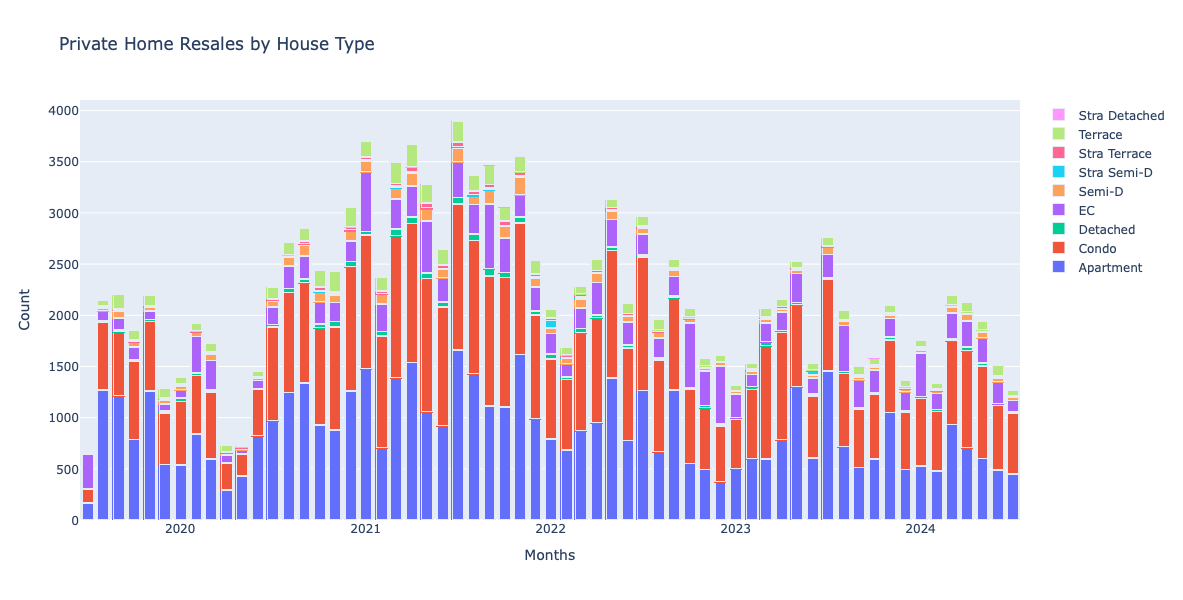

In [267]:
fig = go.Figure()
data = list()
for i in housing_grps:
    fig.add_trace(go.Bar(name=i, 
                         x=house_grps[house_grps['type'] == i][period].tolist(), 
                         y=house_grps[house_grps['type'] == i]['count'].tolist(),
                         # marker_color=price_grps_dict[i]
                        )
                 )

fig.update_layout(
    barmode='stack',
    xaxis={'title':'Months'},
    yaxis={'title':'Count'},
    hovermode="x unified",
    title="Private Home Resales by House Type",
    width=chart_width, height=chart_height,
)
fig.show()

#### Some analysis 
1. Looking at the entire distribution of private housing prices, we can see quite wide variances, with private homes that are as expensive as 80 million SGD. This wide difference in private home prices, as compared to public home prices, do indicate the powers of a strong market regulatory effect that is applied to our public housing prices. 
1. When I look at psf instead, the prices look more reasonable, but this makes it more difficult to compare to my previous public housing narratives, and I shall just keep this in view. 
1. One interesting is to focus first on EC homes, which I understand used to be public homes that became private after 10 years of their launch. Their price patterns look more similar to what we see from public homes, and may be a reflection of the lingering effects of government regulation that comes from its original public housing status.
1. The other interesting thing I realised is the boxplots become unusable when I focus just on "Apartments" and "Condos", as their price patterns are being pulled apart by the presence of extreme outliers. Interestingly, boxplots for the other private homes, including landed properties, actually exhibit stronger clustering of prices, although they do cluster at higher price points compared to our public homes and ECs. This strongly suggests that "Apartments" and "Condos" have a wide variety of quality, including differences between "freehold" and "leasehold", unit sizes, and location. In particular, due to strong zoning restrictions in Singapore, near locational proxities of different private landed properties housing enclaves could potentially limit the variance of their prices, whereas "Apartments" and "Condos" do not. 

#### Caveats
1. There are unit of sales that are more than 
1. Area comes in square metres, and I made square feets conversions using sqaure metres * 10.76391042

#### Testing Boxplots 

In [271]:
# tmp = fdf[fdf.area_type == 'Strata']
# tmp = fdf[fdf['type'].isin(['Apartment', 'Condo', 'EC'])]
# tmp = fdf[fdf['type'].isin(['Apartment', 'EC'])]

In [275]:
def quick_boxplot(house_type:str, col: str):
    tmp = fdf[fdf['type'].isin([house_type])]
    fig = go.Figure()
    for p in tmp['date'].drop_duplicates():
        fig.add_trace(go.Box(
            y=tmp[tmp['date'] == p][col],
            name=str(p),
            boxpoints='outliers',
            marker_color='#06C',
            line_color='#06C',
            showlegend=False
        ))

    fig.update_layout(
        title=f'{house_type} Distributions',
        yaxis={"title": "Home Prices"},
        xaxis={"title": "Months"},
        width=chart_width, height=chart_height,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
    )
    return fig.show()

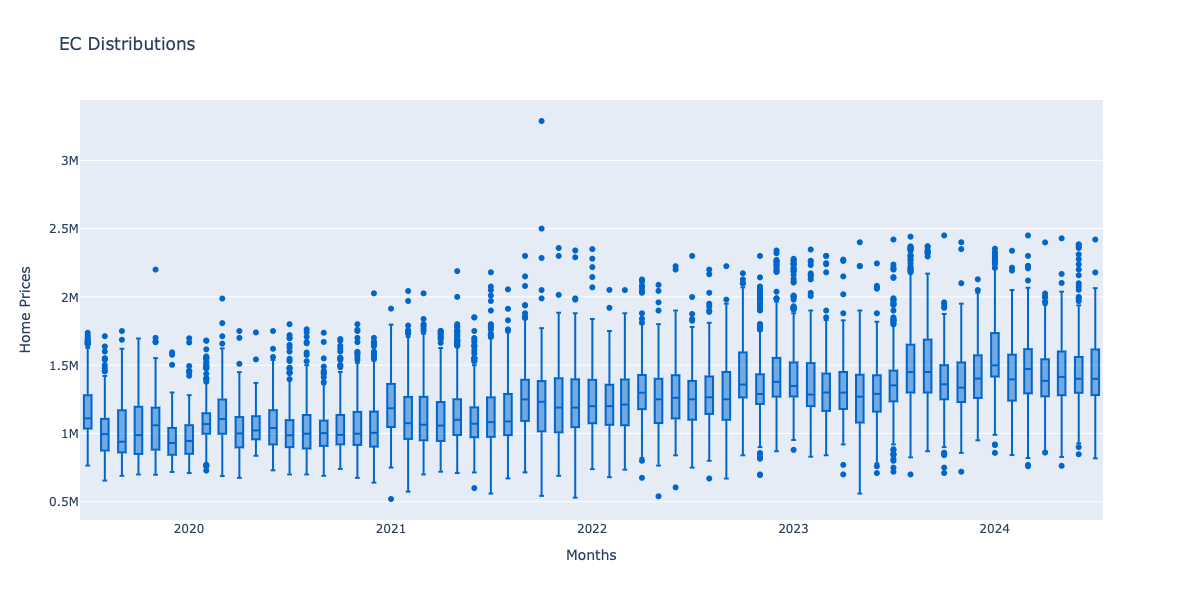

None


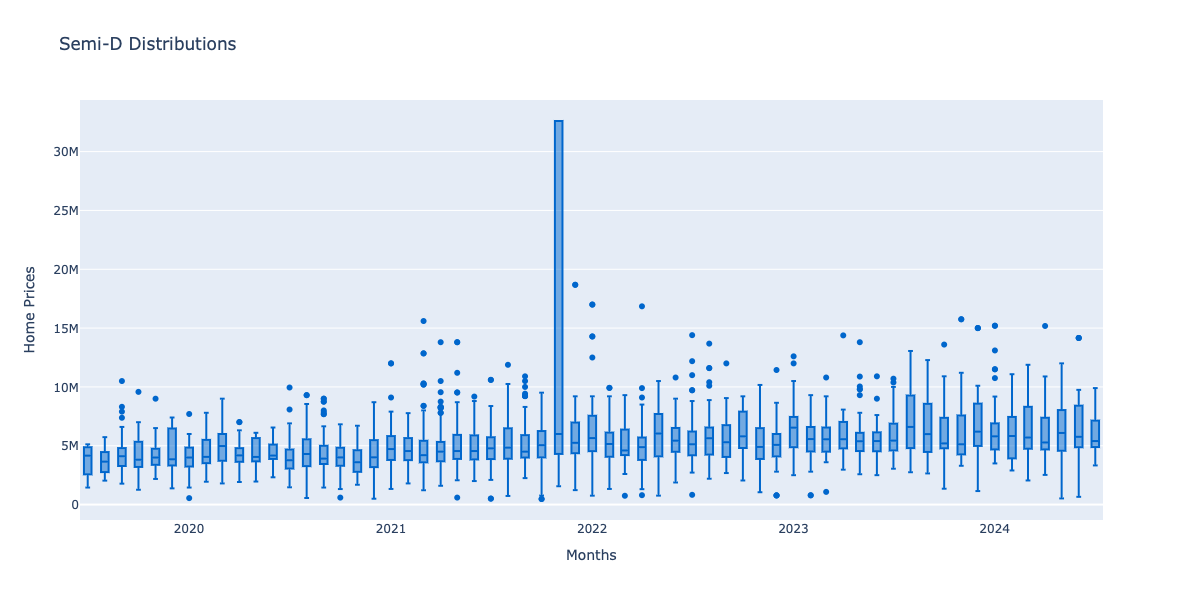

None


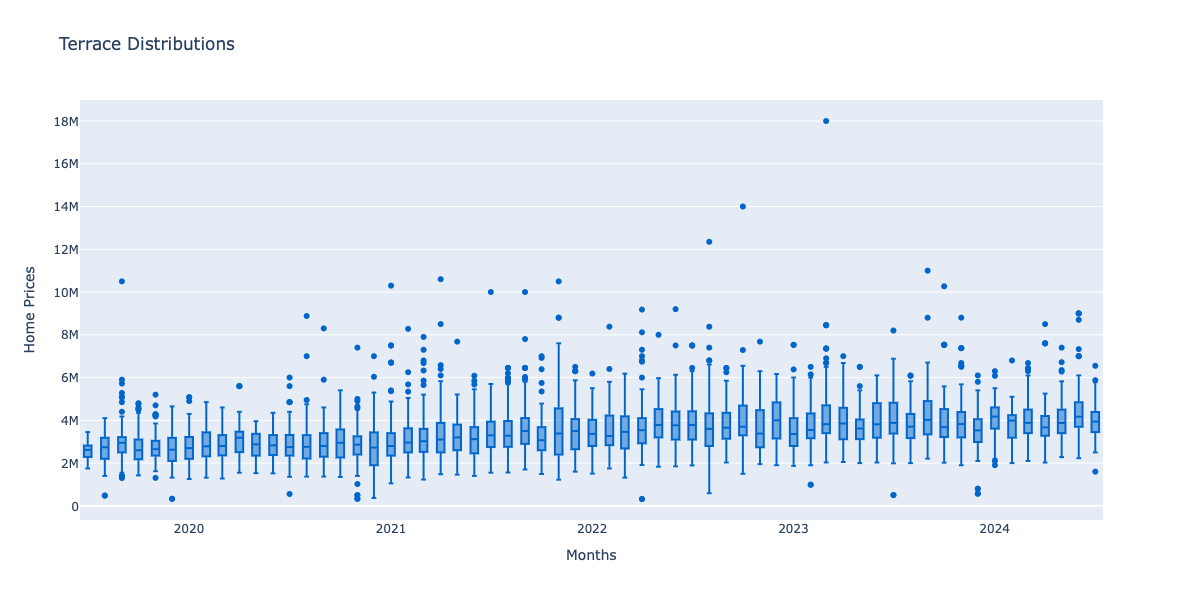

None


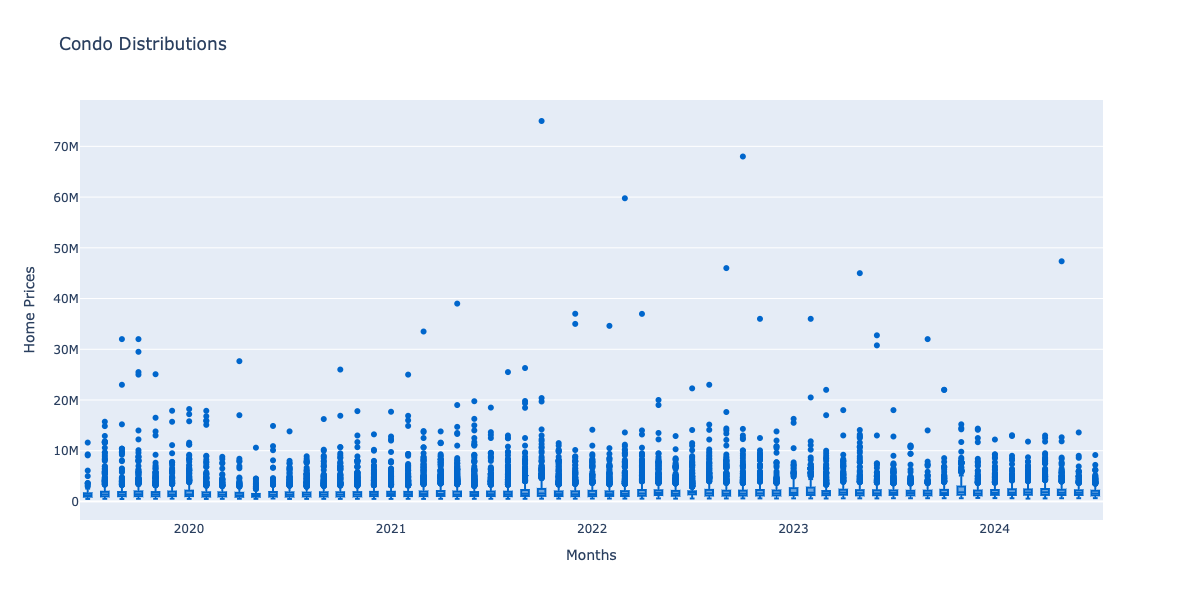

None


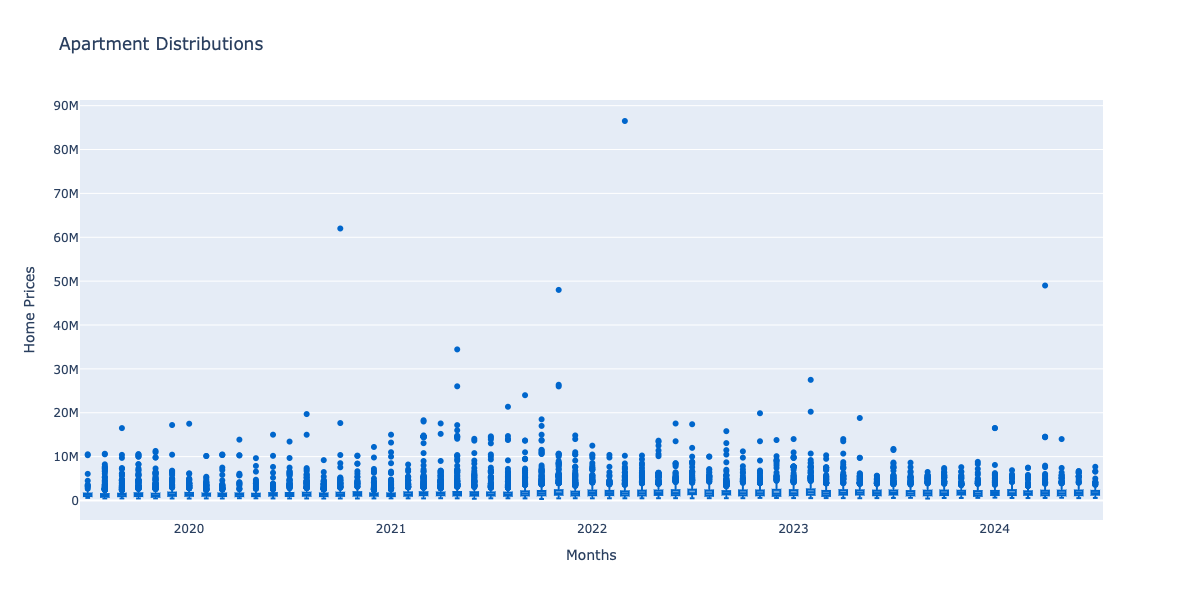

None


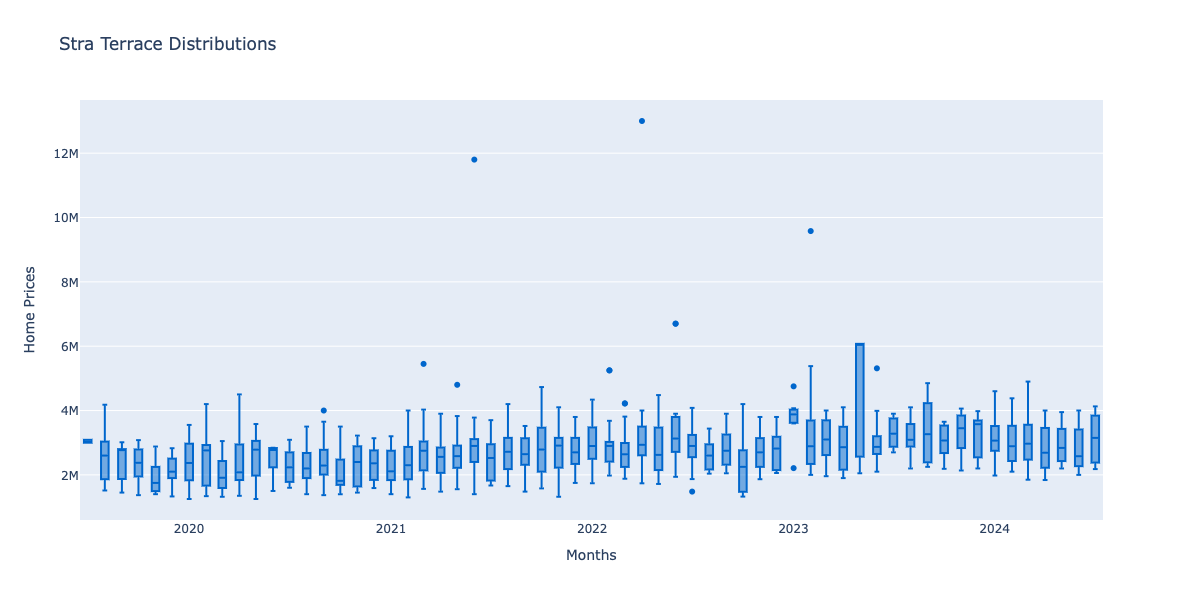

None


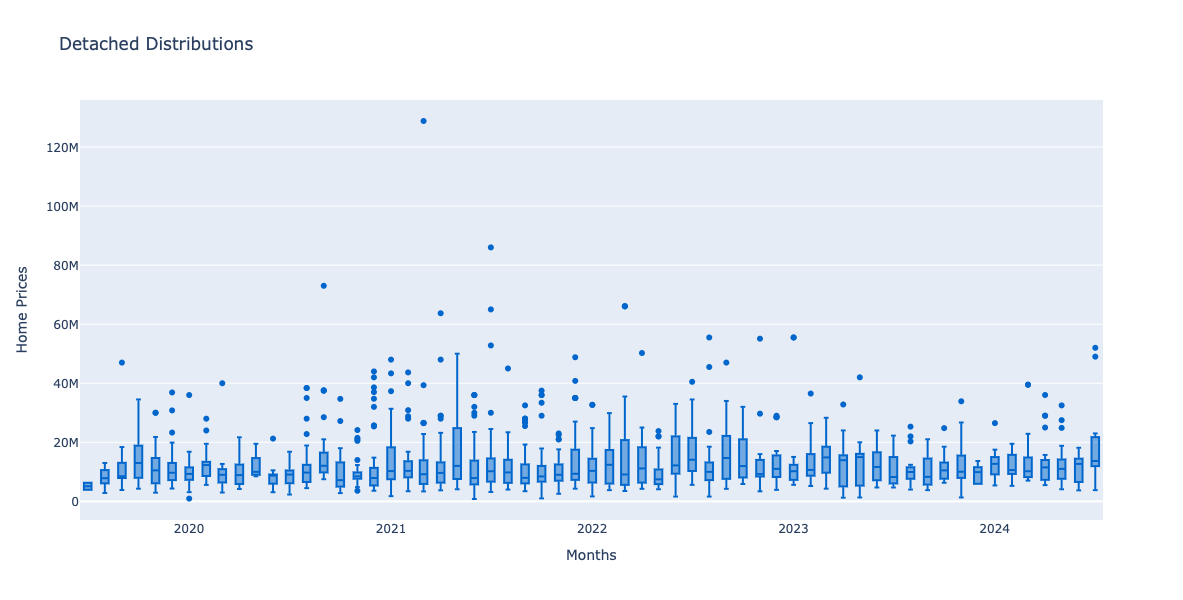

None


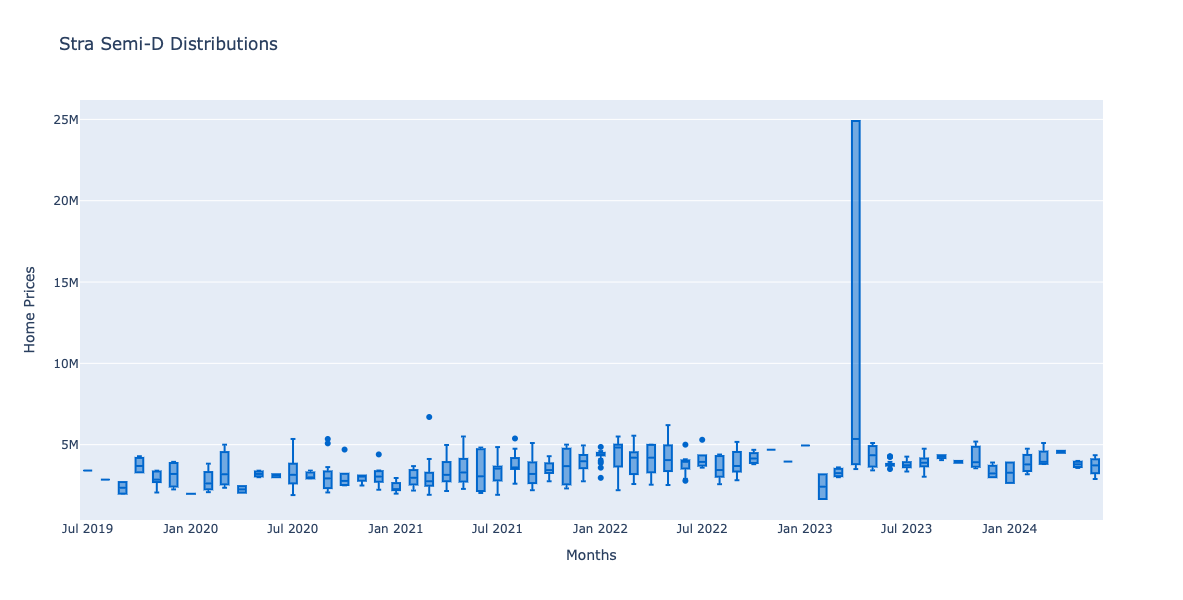

None


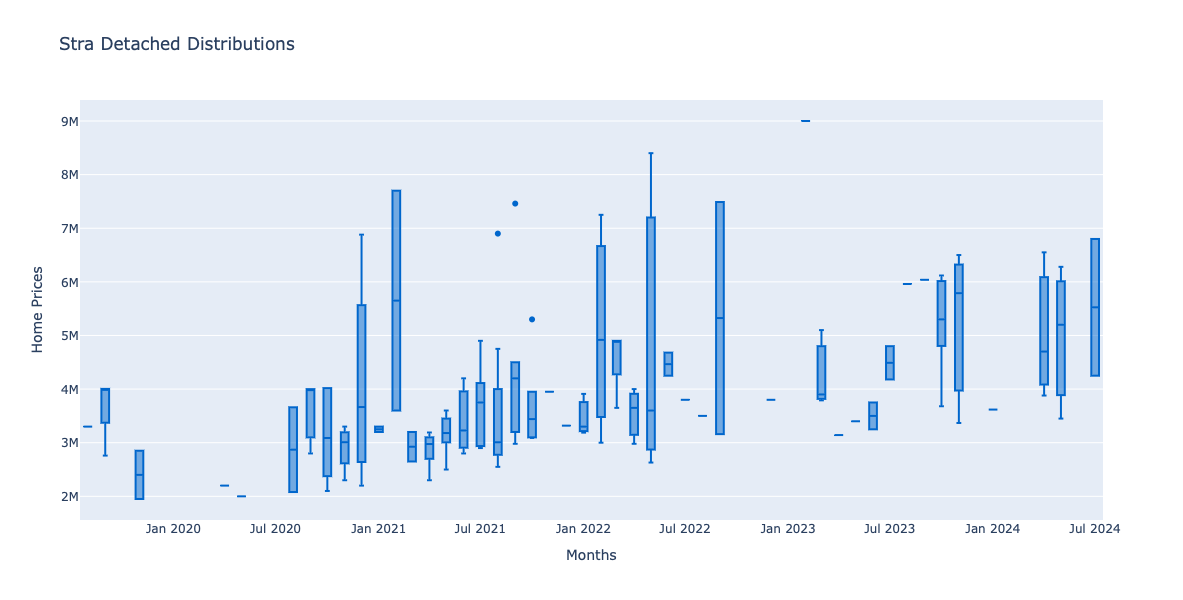

None


In [279]:
for t in fdf['type'].unique().tolist():
    print(quick_boxplot(t, "final_price"))